In [4]:
import networkx as nx
from thewalrus import hafnian
from tqdm import tqdm
import numpy as np
import random 
import matplotlib.pyplot as plt
import copy

# 设置全局字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({"font.size": 16})

# 启用 LaTeX 渲染
plt.rcParams["text.usetex"] = True
# Number of vertexes
n = 256

# @Shuo bipartite probablistic graph
# G0 = nx.complete_bipartite_graph(n//2, n//2)
random.seed(7)
G0 = nx.Graph()
# bipartitle nodes sets
left_nodes = range(n//2)
right_nodes = range(n//2, n)
# mark bipartite
G0.add_nodes_from(left_nodes, bipartite=0)
G0.add_nodes_from(right_nodes, bipartite=1)
# random generate edge
for u in left_nodes:
    for v in right_nodes:
        if random.random() < 0.2:
            G0.add_edge(u, v)
np.save("./Data/bipartite/G0_256.npy", nx.to_numpy_array(G0))

# @Rui graph-1 for 80-densest subgraph: vertex i has edges to vertices 0, 1, …, n-1-i
adj_matrix = np.zeros((n, n), dtype=int) 
for i in range(n):
    adj_matrix[i, :n-i] = 1
    adj_matrix[i, i] = 0
# Make sure the matrix is symmetric since it's an undirected graph
adj_matrix = np.triu(adj_matrix) + np.triu(adj_matrix, 1).T
G1 = nx.from_numpy_array(adj_matrix)

# @Rui graph-2 for finding 12-subgraph with max-hafnian: containing 12-complete graph and remaining edge with probability 0.2
G2 = nx.Graph()
np.random.seed(7)

# Select 12 nodes to form a complete subgraph
nodes_to_connect = list(range(n))
np.random.shuffle(nodes_to_connect)
complete_subgraph_nodes = nodes_to_connect[:12]
G2.add_nodes_from(range(n)) 
G2.add_edges_from(nx.complete_graph(complete_subgraph_nodes).edges())

# Randomly select the remaining edges with probability 0.2
for i in range(n):
    for j in range(i+1, n):
        if (i in complete_subgraph_nodes and j in complete_subgraph_nodes) or np.random.rand() >= 0.2:
            continue
        G2.add_edge(i, j)
        
def calculate_hafnian(subgraph):
    # Convert the subgraph to an adjacency matrix
    adj_matrix = nx.to_numpy_array(subgraph)
    return abs(hafnian(adj_matrix)) # Complex number

def calculate_density(subgraph):
    # Calculate the density of the subgraph
    num_nodes = subgraph.number_of_nodes()
    num_edges = subgraph.number_of_edges()
    if num_nodes < 2:
        return 0  # Avoid division by zero
    density = num_edges / num_nodes
    return density

print(calculate_density(G0))

12.76171875


In [ ]:
# Initial matching is empty set
def glauber_dynamics(G, k, c, mixing_time):
    matching = set()
    post_select_subgraph = list()
    
    for _ in range(mixing_time):
        # Randomly select an edge
        e = random.choice(list(G.edges()))
        u, v = e
        # Check the status of the selected edge
        if all(node not in list(n for edge in matching for n in edge) for node in e):
            # Both u and v are not in the matching
            if np.random.rand() <= c**2 / (1 + c**2):
                matching.add(e)
        elif e in matching:
            # Both u and v are in the matching
            if np.random.rand() <= 1 / (1 + c**2):
                matching.remove(e)
        
        # Check if the matching is a k-subgraph
        if 2 * len(matching) == k:
            post_select_subgraph.append(G.subgraph(G.edge_subgraph(matching).nodes()))
        
    return post_select_subgraph[-1]

def jerrum_glauber_dynamics(G, k, c, mixing_time):
    # Initial matching is an empty set
    matching = set()
    post_select_subgraph = list()

    for _ in range(mixing_time):
        # Select an edge uniformly at random
        e = random.choice(list(G.edges))
        u, v = e

        # Check the status of the selected edge
        flag = 0
        nodes = set()
        for edge in matching:
            n1, n2 = edge
            nodes.add(n1)
            nodes.add(n2)
        if (u in nodes) or (v in nodes):
            flag = 1
        if (u in nodes) and (v in nodes):
            flag = 2
        # update
        if flag == 0:
            new_matching = matching | {e}
        elif flag == 1:
            for edge in matching:
                if (u in edge) or (v in edge):
                    alternative_edge = edge
                    new_matching = (matching - {alternative_edge}) | {e}
                    break
        else:
            if e in matching:
                new_matching = matching - {e}
            else:
                new_matching = matching

        # Calculate acceptance probability
        old_weight = c ** (2*len(matching))
        new_weight = c ** (2*len(new_matching))
        acceptance_probability = min(1, new_weight / old_weight)

        # Accept or reject the new matching
        if random.random() < acceptance_probability:
            matching = new_matching
        
        # Check if the matching is a k-subgraph
        if 2 * len(matching) == k:
            post_select_subgraph.append(G.subgraph(G.edge_subgraph(matching).nodes()))

    return post_select_subgraph[-1]

def double_loop_glauber_dynamics(G, k, c, mixing_time):
    # G is a bipartite graph
    matching = set()
    post_select_subgraph = list()
    
    for _ in range(mixing_time):
        # Randomly select an edge
        e = random.choice(list(G.edges()))
        # Check the status of the selected edge
        if all(node not in list(n for edge in matching for n in edge) for node in e):
            # Both u and v are both not in the matching
            if np.random.rand() <= c**4 / (1 + c**4):
                matching.add(e)
        elif e in matching:
            # Both u and v are in the matching
            uniform_matching = matching
            subgraph = G.subgraph(G.edge_subgraph(matching).nodes())
            # Uniformly sample a perfect matching from the subgraph
            for _ in range(mixing_time // 10):
                if len(uniform_matching) == len(subgraph.nodes())//2: # is perfect matching
                    new_e = random.choice(list(subgraph.edges()))
                    new_uniform_matching = uniform_matching - {new_e}
                elif len(uniform_matching) == len(subgraph.nodes())//2 -1: # is approximate perfect matching
                    missing_point = set(subgraph.nodes())-set(n for edge in uniform_matching for n in edge)
                    u = list(missing_point)[0]
                    v = list(missing_point)[1]
                    new_e = random.choice(list(subgraph.edges()))
                    if (u in new_e and v in new_e):
                        new_uniform_matching = uniform_matching | {new_e}
                    elif (u in new_e and not(v in new_e)):
                        for edge in uniform_matching:
                            for n in edge:
                                if n in new_e:
                                    new_uniform_matching = uniform_matching - {edge} | {new_e}
                                    break
                    elif (v in new_e and not(u in new_e)):
                        for edge in uniform_matching:
                            for n in edge:
                                if n in new_e:
                                    new_uniform_matching = uniform_matching - {edge} | {new_e}
                                    break
                    else:
                        new_uniform_matching = uniform_matching
                    
                if np.random.rand() < min(1, 1):
                    uniform_matching = new_uniform_matching
                    
            if e in uniform_matching:
                if np.random.rand() <= 1 / (1 + c**4):
                    matching.remove(e)
        
        # Check if the matching is a k-subgraph
        if 2 * len(matching) == k:
            post_select_subgraph.append(G.subgraph(G.edge_subgraph(matching).nodes()))
        
    return post_select_subgraph[-1]

In [6]:
def random_search(G, k, iteration):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d submatrix of A, randomly
        Ai = random.sample(nodes, k)
        Ai_subgraph = G.subgraph(Ai)
        f_Ai = calculate_density(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

def glauber_random_search(G, k, c, iteration, mixing_time):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d of A by Glauber Dynamics
        Ai_subgraph = glauber_dynamics(G, k, c, mixing_time)
        f_Ai = calculate_density(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

def jerrum_glauber_random_search(G, k, c, iteration, mixing_time):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d of A by Glauber Dynamics
        Ai_subgraph = jerrum_glauber_dynamics(G, k, c, mixing_time)
        f_Ai = calculate_density(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

def double_loop_glauber_random_search(G, k, c, iteration, mixing_time):
    nodes = list(G.nodes)
    Best = 0
    AB_subgraph = None
    List = [Best]
    
    for _ in range(iteration):
        # Choose Ai, a k-d of A by Glauber Dynamics
        Ai_subgraph = double_loop_glauber_dynamics(G, k, c, mixing_time)
        f_Ai = calculate_density(Ai_subgraph)
        
        if f_Ai > Best:
            Best = f_Ai
            AB_subgraph = Ai_subgraph
        List.append(Best)
        
    return List, AB_subgraph, Best

100%|██████████| 10/10 [1:34:44<00:00, 568.45s/it] 


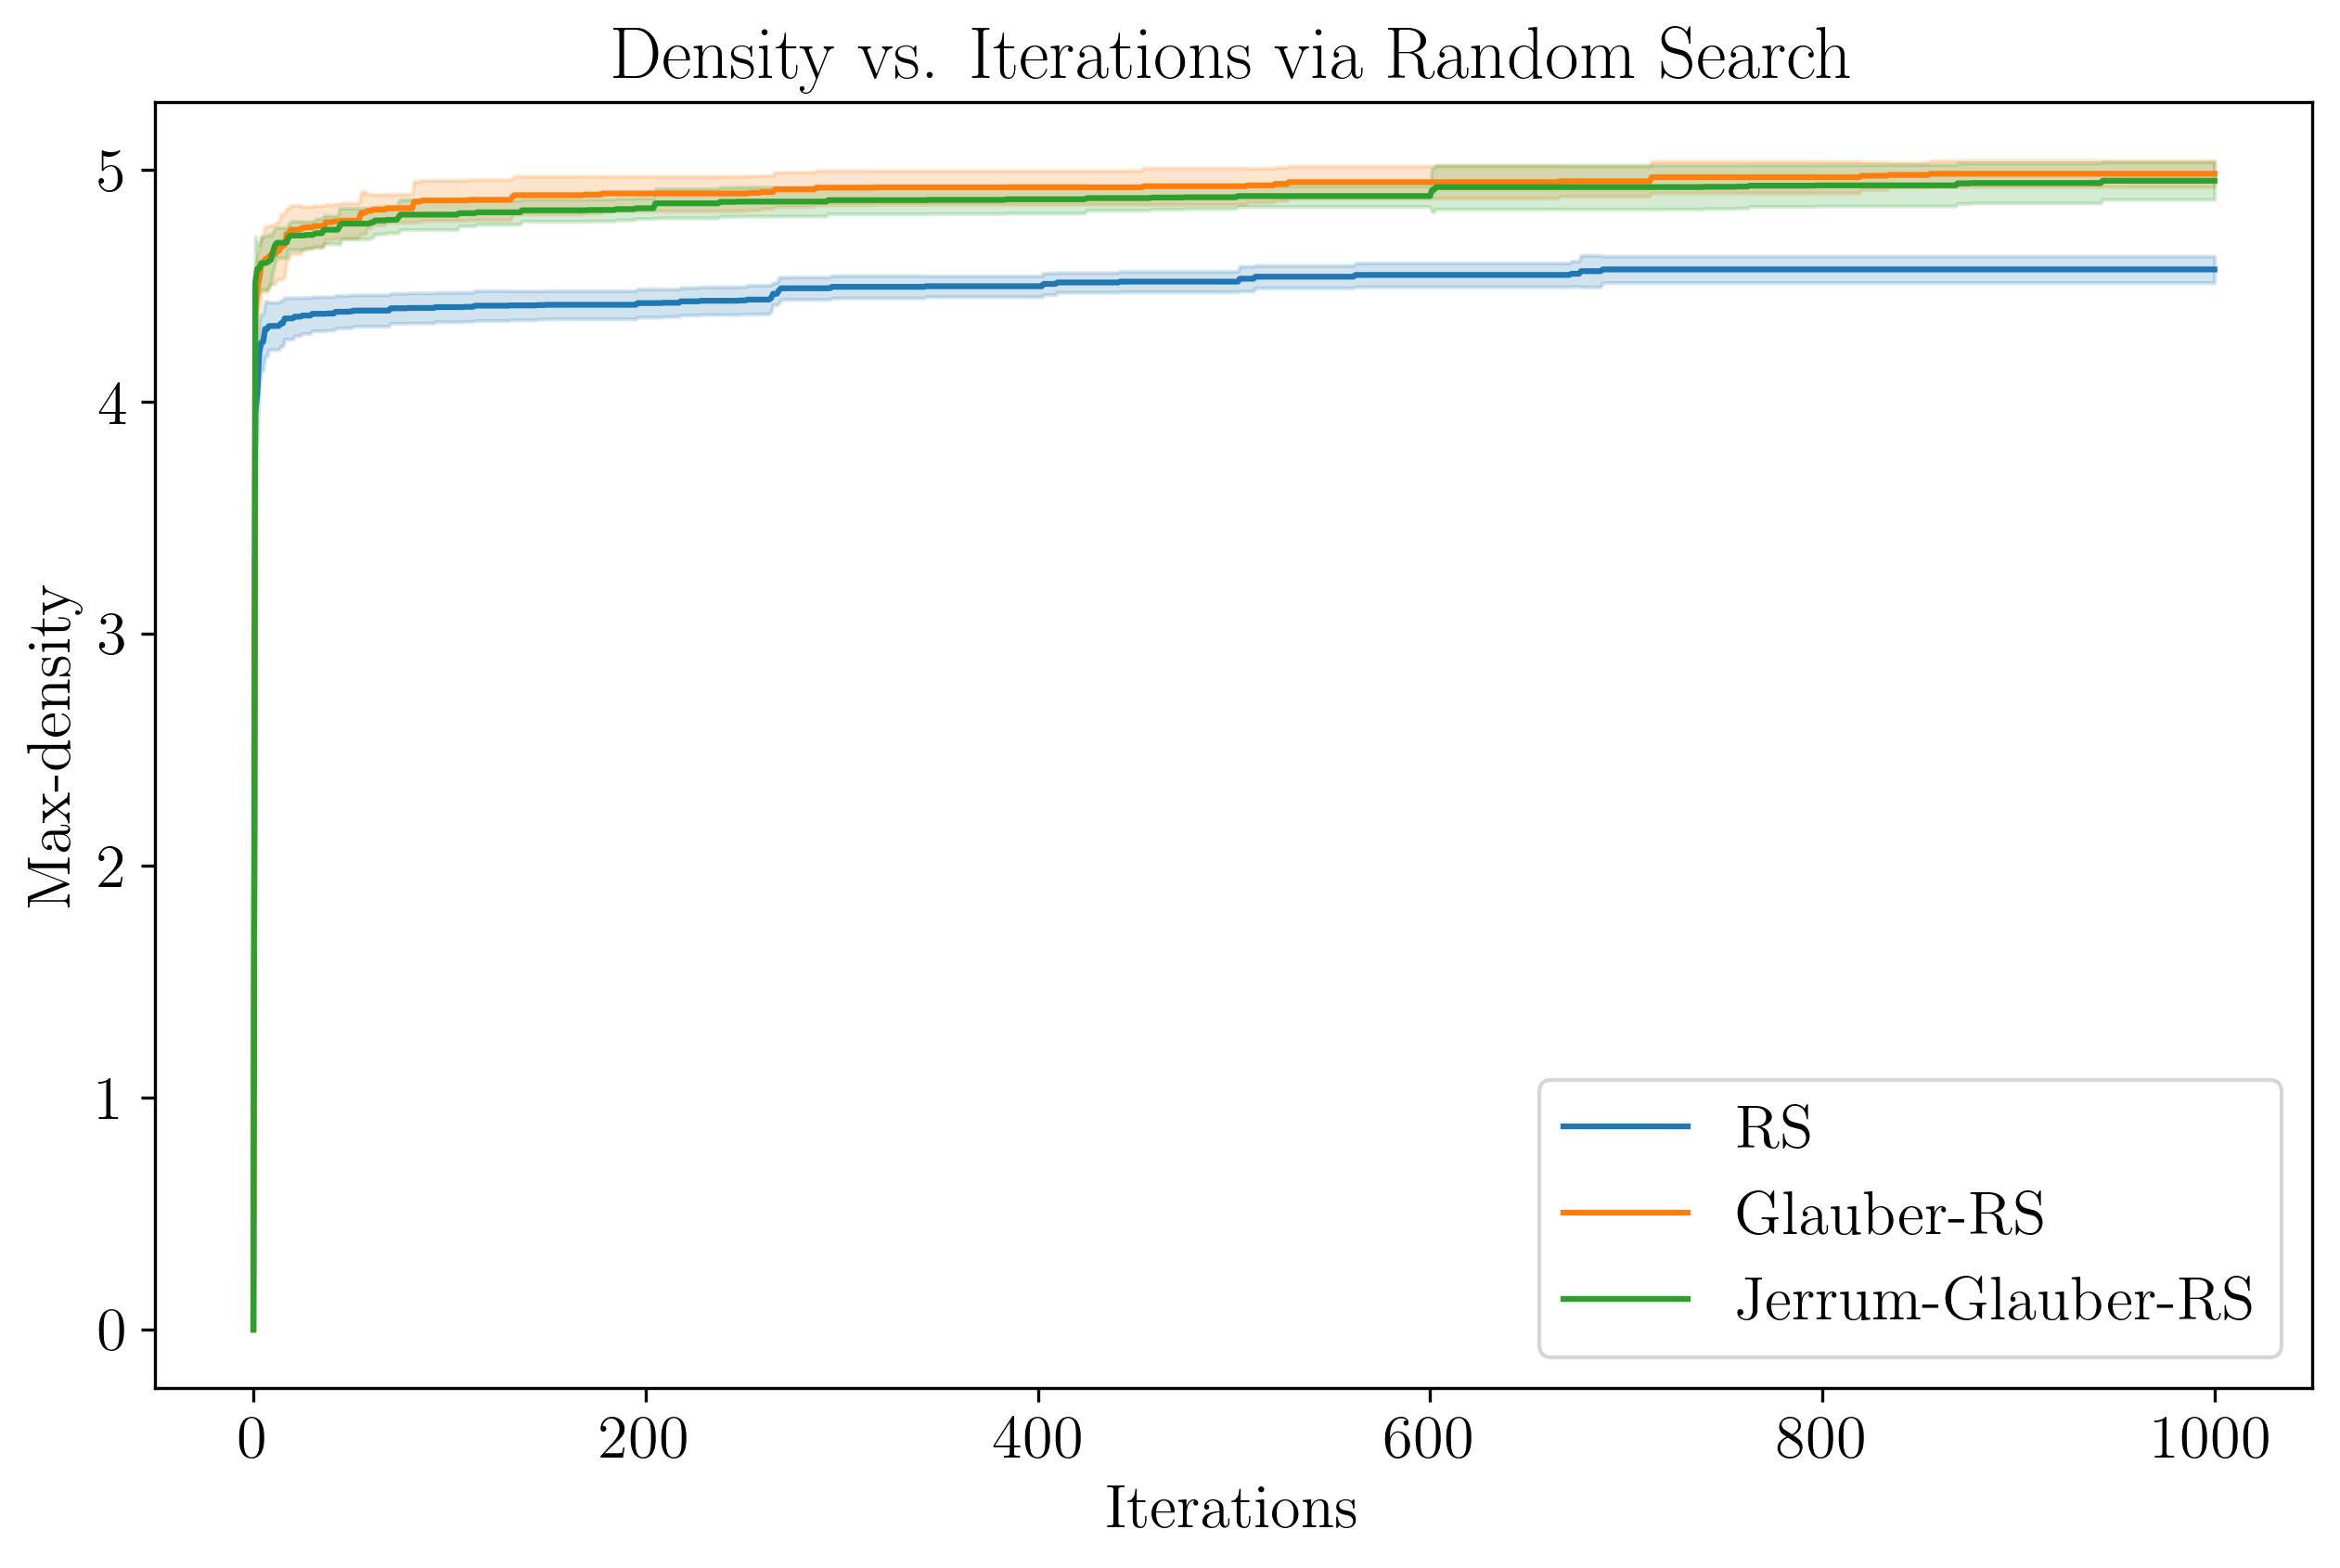

In [7]:
# Plot the density of the 80-node subgraph with the maximum density using Random Search
G = G0
c = 0.8 # fugacity
k = 80
iteration = 1000
mixing_time = 1000
plt.figure(figsize=(10, 6), dpi=300)

# Finding the 80-node subgraph with the maximum density using Random Search
max_density_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    max_density_list[i], best_subgraph, best_hafnian = random_search(G, k, iteration)

np.save("./Data/bipartite/RS_density_list.npy", max_density_list)
mean_density_values = np.mean(max_density_list, axis=0)
std_density_values = np.std(max_density_list, axis=0)

plt.plot(mean_density_values, label="RS", color='C0')
plt.fill_between(range(iteration+1), mean_density_values - std_density_values, mean_density_values + std_density_values, color = 'C0', alpha=0.2)

# Finding the 80-node subgraph with the maximum density using Glauber Random Search
glauber_max_density_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    glauber_max_density_list[i], glauber_best_subgraph, glauber_best_hafnian = glauber_random_search(G, k, c, iteration, mixing_time)

np.save("./Data/bipartite/glauber_RS_density_list.npy", glauber_max_density_list)
mean_glauber_density_values = np.mean(glauber_max_density_list, axis=0)
std_glauber_density_values = np.std(glauber_max_density_list, axis=0)

plt.plot(mean_glauber_density_values, label="Glauber-RS", color='C1')
plt.fill_between(range(iteration+1), mean_glauber_density_values - std_glauber_density_values, mean_glauber_density_values + std_glauber_density_values, color = 'C1', alpha=0.2)

# Finding the 80-node subgraph with the maximum density using Jerrum Glauber Random Search
jerrum_glauber_max_density_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    jerrum_glauber_max_density_list[i], jerrum_glauber_best_subgraph, jerrum_glauber_best_hafnian = jerrum_glauber_random_search(G, k, c, iteration, mixing_time)

np.save("./Data/bipartite/jerrum_glauber_RS_density_list.npy", jerrum_glauber_max_density_list)
mean_jerrum_glauber_density_values = np.mean(jerrum_glauber_max_density_list, axis=0)
std_jerrum_glauber_density_values = np.std(jerrum_glauber_max_density_list, axis=0)

plt.plot(mean_jerrum_glauber_density_values, label="Jerrum-Glauber-RS", color='C2')
plt.fill_between(range(iteration+1), mean_jerrum_glauber_density_values - std_jerrum_glauber_density_values, mean_jerrum_glauber_density_values + std_jerrum_glauber_density_values, color = 'C2', alpha=0.2)

# # Finding the 80-node subgraph with the maximum density using Double-Loop Glauber Random Search
# double_loop_glauber_max_density_list = np.zeros((10, iteration+1))
# for i in tqdm(range(10)):
#     double_loop_glauber_max_density_list[i], double_loop_glauber_best_subgraph, double_loop_glauber_best_hafnian = double_loop_glauber_random_search(G, k, c, iteration, mixing_time)
# 
# np.save("./Data/bipartite/double_loop_glauber_RS_density_list.npy", double_loop_glauber_max_density_list)
# mean_double_loop_glauber_density_values = np.mean(double_loop_glauber_max_density_list, axis=0)
# std_double_loop_glauber_density_values = np.std(double_loop_glauber_max_density_list, axis=0)
# 
# plt.plot(mean_double_loop_glauber_density_values, label="Double-Loop-Glauber-RS", color='C3')
# plt.fill_between(range(iteration+1), mean_double_loop_glauber_density_values - std_double_loop_glauber_density_values, mean_double_loop_glauber_density_values + std_double_loop_glauber_density_values, color = 'C3', alpha=0.2)

plt.xlabel("Iterations")
plt.ylabel("Max-density")
plt.title("Density vs. Iterations via Random Search")
plt.legend(loc = "lower right")
plt.savefig("./Figure/double_loop_density_random_search.pdf")
plt.show()

In [8]:
subgraph3 = glauber_dynamics(G0, k=16, c=0.4, mixing_time=1000)

In [9]:
def simulated_annealing(G, k, iteration, t_initial):
    nodes = list(G.nodes)
    # Randomly generate a binary vector S with k entries being nonzero
    S = np.zeros(len(nodes))
    S[:k] = 1
    np.random.shuffle(S)
    AS_nodes = np.where(S == 1)[0]
    AS_subgraph = G.subgraph(AS_nodes)
    AB_subgraph = AS_subgraph
    Best = calculate_density(AS_subgraph)
    List = [Best]
    
    t = t_initial
    for _ in range(iteration):
        
        # Generate an integer m in [0, k-1]
        m = random.randint(0, k-1)

        #  Shuffle m nonzero entries of S
        nonzero_indices = np.where(S == 1)[0]
        zero_indices = np.where(S == 0)[0]
        # Find the indices of the entries that are not shuffled
        fixed_indices = random.sample(list(nonzero_indices), m)
        remaining_indices = list(set(nonzero_indices) - set(fixed_indices)) + list(zero_indices)
        random.shuffle(remaining_indices)
        # Construct a new binary vector R
        R = np.zeros(n, dtype=int)
        R[fixed_indices] = 1
        R[remaining_indices[:k-m]] = 1

        # Construct the subgraph AR
        AR_nodes = np.where(R == 1)[0]
        AR_subgraph = G.subgraph(AR_nodes)

        f_AR = calculate_density(AR_subgraph)
        f_AS = calculate_density(AS_subgraph)
        
        if f_AR > f_AS:
            if f_AR > Best:
                Best = f_AR
                AB_subgraph = AR_subgraph
            S = R
            AS_subgraph = AR_subgraph  # Update A_S
        else:
            if random.random() < np.exp((f_AR - f_AS) / t):
                S = R
                AS_subgraph = AR_subgraph  # Update A_S
        
        List.append(Best)
        # Decrease t
        t *= 0.95
    
    return List, AB_subgraph, Best

def glauber_simulated_annealing(G, k, c, iteration, mixing_time, t_initial):
    nodes = list(G.nodes)
    # Initialize S by Glauber Dynamics
    S = np.zeros(len(nodes))
    initial = list(glauber_dynamics(G, k, c, mixing_time).nodes)
    S[initial] = 1
    AS_nodes = np.where(S == 1)[0]
    AS_subgraph = G.subgraph(AS_nodes)
    AB_subgraph = AS_subgraph
    Best = calculate_density(AS_subgraph)
    List = [Best]
    
    t = t_initial
    for _ in range(iteration):
        # Original from scratch search AR_subgraph = glauber_dynamics(G, k, c, mixing_time)
        # Generate an integer m in [0, k-1]
        m = random.randint(0, k-1)  
        
        nonzero_indices = np.where(S == 1)[0]
        zero_indices = np.where(S == 0)[0]
        s = set(random.sample(list(nonzero_indices), m)) # fixed indices
        
        # Glauber Dynamics until S and R has no intersection
        r = set(glauber_dynamics(G, k, c, mixing_time).nodes)
        intersection = s & r
        r = r - intersection
        r = r - set(random.sample(list(r), m - len(intersection)))
        
        AR_subgraph = G.subgraph(s | r)  
          
        R = np.zeros(len(nodes))
        for i in range(len(nodes)):
            if i in list(AR_subgraph.nodes):
                R[i] = 1
    
        f_AR = calculate_density(AR_subgraph)
        f_AS = calculate_density(AS_subgraph)
        
        if f_AR > f_AS:
            if f_AR > Best:
                Best = f_AR
                AB_subgraph = AR_subgraph
            S = R
            AS_subgraph = AR_subgraph  # Update A_S
        else:
            if random.random() < np.exp((f_AR - f_AS) / t):
                S = R
                AS_subgraph = AR_subgraph  # Update A_S
        
        List.append(Best)
        # Decrease t
        t *= 0.95
    
    return List, AB_subgraph, Best

def jerrum_glauber_simulated_annealing(G, k, c, iteration, mixing_time, t_initial):
    nodes = list(G.nodes)
    # Initialize S by Glauber Dynamics
    S = np.zeros(len(nodes))
    initial = list(jerrum_glauber_dynamics(G, k, c, mixing_time).nodes)
    S[initial] = 1
    AS_nodes = np.where(S == 1)[0]
    AS_subgraph = G.subgraph(AS_nodes)
    AB_subgraph = AS_subgraph
    Best = calculate_density(AS_subgraph)
    List = [Best]
    
    t = t_initial
    for _ in range(iteration):
        # Original from scratch search AR_subgraph = glauber_dynamics(G, k, c, mixing_time)
        # Generate an integer m in [0, k-1]
        m = random.randint(0, k-1)  
        
        nonzero_indices = np.where(S == 1)[0]
        zero_indices = np.where(S == 0)[0]
        s = set(random.sample(list(nonzero_indices), m)) # fixed indices
        
        # Glauber Dynamics until S and R has no intersection
        r = set(jerrum_glauber_dynamics(G, k, c, mixing_time).nodes)
        intersection = s & r
        r = r - intersection
        r = r - set(random.sample(list(r), m - len(intersection)))
        
        AR_subgraph = G.subgraph(s | r)
            
        R = np.zeros(len(nodes))
        for i in range(len(nodes)):
            if i in list(AR_subgraph.nodes):
                R[i] = 1
        f_AR = calculate_density(AR_subgraph)
        f_AS = calculate_density(AS_subgraph)
        
        if f_AR > f_AS:
            if f_AR > Best:
                Best = f_AR
                AB_subgraph = AR_subgraph
            S = R
            AS_subgraph = AR_subgraph  # Update A_S
        else:
            if random.random() < np.exp((f_AR - f_AS) / t):
                S = R
                AS_subgraph = AR_subgraph  # Update A_S
        
        List.append(Best)
        # Decrease t
        t *= 0.95
    
    return List, AB_subgraph, Best

def double_loop_glauber_simulated_annealing(G, k, c, iteration, mixing_time, t_initial):
    nodes = list(G.nodes)
    # Initialize S by Glauber Dynamics
    S = np.zeros(len(nodes))
    initial = list(double_loop_glauber_dynamics(G, k, c, mixing_time).nodes)
    S[initial] = 1
    AS_nodes = np.where(S == 1)[0]
    AS_subgraph = G.subgraph(AS_nodes)
    AB_subgraph = AS_subgraph
    Best = calculate_density(AS_subgraph)
    List = [Best]
    
    t = t_initial
    for _ in range(iteration):
        # Original from scratch search AR_subgraph = glauber_dynamics(G, k, c, mixing_time)
        # Generate an integer m in [0, k-1]
        m = random.randint(0, k-1)  
        
        nonzero_indices = np.where(S == 1)[0]
        zero_indices = np.where(S == 0)[0]
        s = set(random.sample(list(nonzero_indices), m)) # fixed indices
        
        # Glauber Dynamics until S and R has no intersection
        r = set(double_loop_glauber_dynamics(G, k, c, mixing_time).nodes)
        intersection = s & r
        r = r - intersection
        r = r - set(random.sample(list(r), m - len(intersection)))
        
        AR_subgraph = G.subgraph(s | r)
            
        R = np.zeros(len(nodes))
        for i in range(len(nodes)):
            if i in list(AR_subgraph.nodes):
                R[i] = 1
        f_AR = calculate_density(AR_subgraph)
        f_AS = calculate_density(AS_subgraph)
        
        if f_AR > f_AS:
            if f_AR > Best:
                Best = f_AR
                AB_subgraph = AR_subgraph
            S = R
            AS_subgraph = AR_subgraph  # Update A_S
        else:
            if random.random() < np.exp((f_AR - f_AS) / t):
                S = R
                AS_subgraph = AR_subgraph  # Update A_S
        
        List.append(Best)
        # Decrease t
        t *= 0.95
    
    return List, AB_subgraph, Best

100%|██████████| 10/10 [53:51<00:00, 323.12s/it]


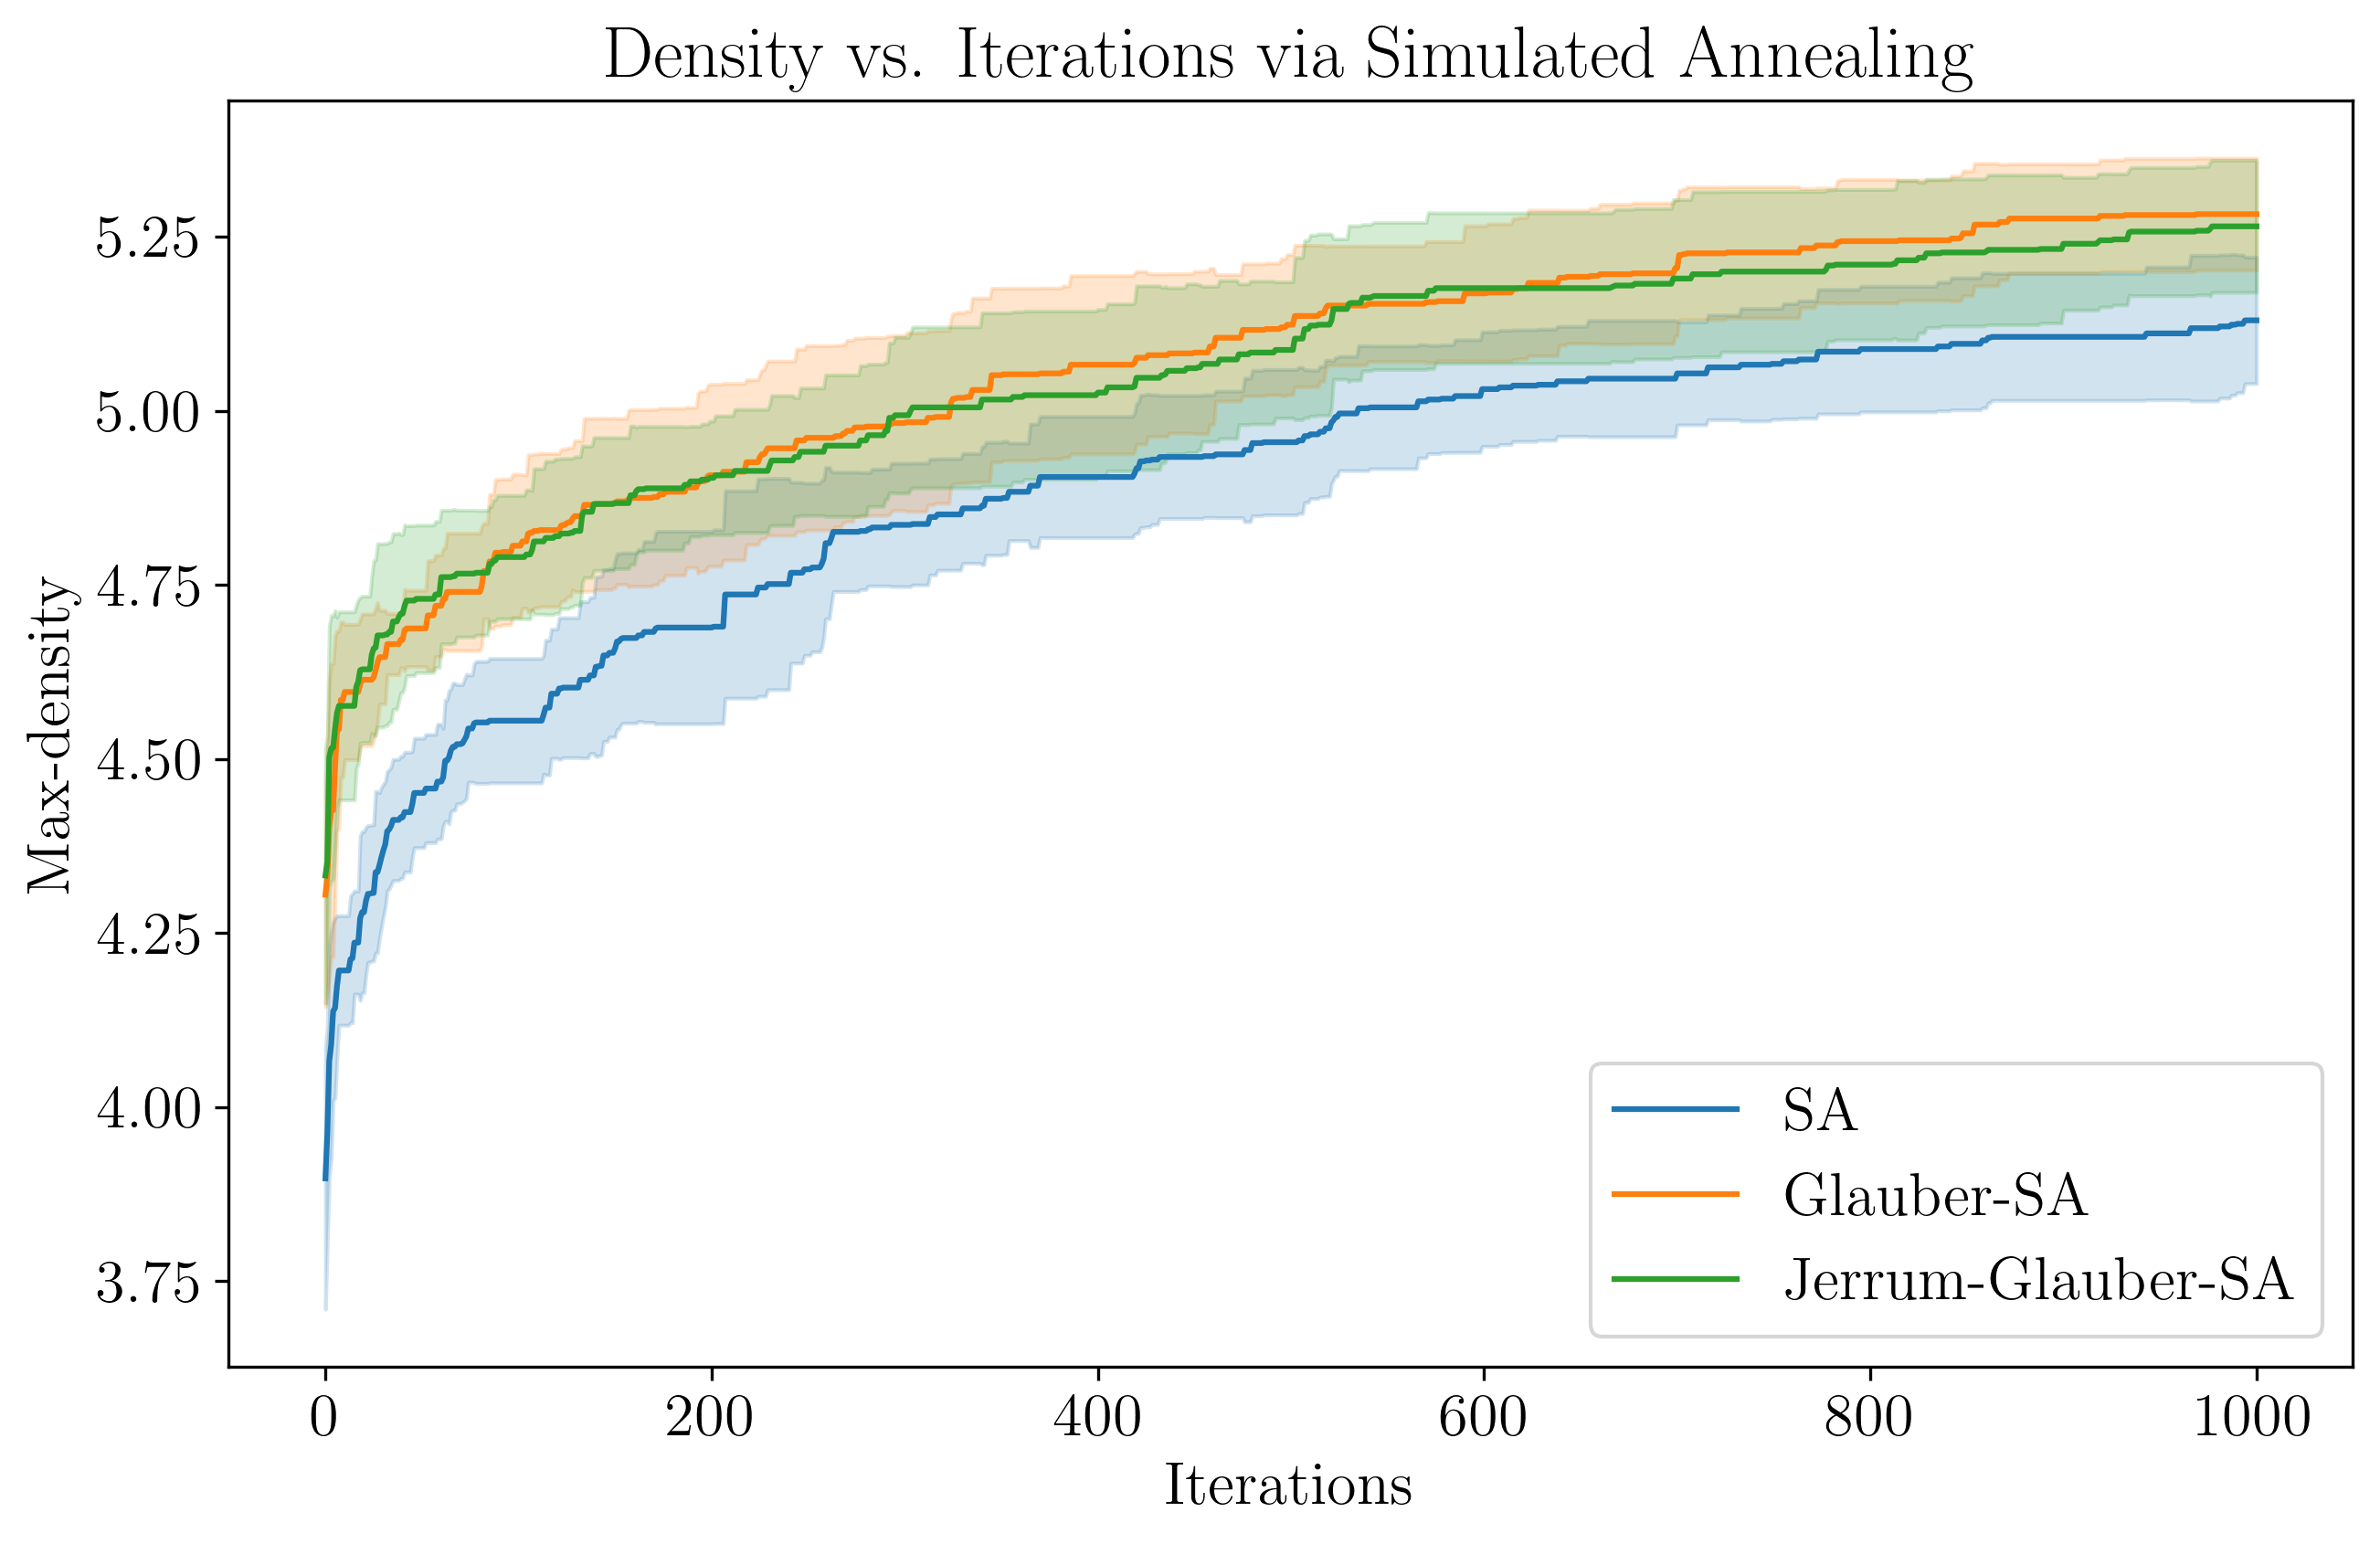

In [10]:
# Plot the density of the 80-node subgraph with the maximum density using Simulated Annealing
G = G0
c = 0.8 # fugacity
k = 80
iteration = 1000
mixing_time = 1000
t_initial = 1.0
plt.figure(figsize=(10, 6), dpi=300)

# Finding the 80-node subgraph with the maximum density using Simulated Annealing
max_density_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    max_density_list[i], best_subgraph, best_hafnian = simulated_annealing(G, k, iteration, t_initial)

np.save("./Data/bipartite/SA_density_list.npy", max_density_list)
mean_density_values = np.mean(max_density_list, axis=0)
std_density_values = np.std(max_density_list, axis=0)

plt.plot(mean_density_values, label="SA", color='C0')
plt.fill_between(range(iteration+1), mean_density_values - std_density_values, mean_density_values + std_density_values, color='C0', alpha=0.2)

# Finding the 80-node subgraph with the maximum density using Glauber Simulated Annealing
glauber_max_density_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    glauber_max_density_list[i], glauber_best_subgraph, glauber_best_hafnian = glauber_simulated_annealing(G, k, c, iteration, mixing_time, t_initial)

np.save("./Data/bipartite/glauber_SA_density_list.npy", glauber_max_density_list)
mean_glauber_density_values = np.mean(glauber_max_density_list, axis=0)
std_glauber_density_values = np.std(glauber_max_density_list, axis=0)

plt.plot(mean_glauber_density_values, label="Glauber-SA", color='C1')
plt.fill_between(range(iteration+1), mean_glauber_density_values - std_glauber_density_values, mean_glauber_density_values + std_glauber_density_values, color = 'C1', alpha=0.2)

# Finding the 80-node subgraph with the maximum density using Jerrum Glauber Simulated Annealing
jerrum_glauber_max_density_list = np.zeros((10, iteration+1))
for i in tqdm(range(10)):
    jerrum_glauber_max_density_list[i], jerrum_glauber_best_subgraph, jerrum_glauber_best_hafnian = jerrum_glauber_simulated_annealing(G, k, c, iteration, mixing_time, t_initial)

np.save("./Data/bipartite/jerrum_glauber_SA_density_list.npy", jerrum_glauber_max_density_list)
mean_jerrum_glauber_density_values = np.mean(jerrum_glauber_max_density_list, axis=0)
std_jerrum_glauber_density_values = np.std(jerrum_glauber_max_density_list, axis=0)

plt.plot(mean_jerrum_glauber_density_values, label="Jerrum-Glauber-SA", color='C2')
plt.fill_between(range(iteration+1), mean_jerrum_glauber_density_values - std_jerrum_glauber_density_values, mean_jerrum_glauber_density_values + std_jerrum_glauber_density_values, color = 'C2', alpha=0.2)

# # Finding the 80-node subgraph with the maximum density using Double-Loop Glauber Simulated Annealing
# double_loop_glauber_max_density_list = np.zeros((10, iteration+1))
# for i in tqdm(range(10)):
#     double_loop_glauber_max_density_list[i], double_loop_glauber_best_subgraph, double_loop_glauber_best_hafnian = double_loop_glauber_simulated_annealing(G, k, c, iteration, mixing_time, t_initial)
# 
# np.save("./Data/bipartite/double_loop_glauber_SA_density_list.npy", double_loop_glauber_max_density_list)
# mean_double_loop_glauber_density_values = np.mean(double_loop_glauber_max_density_list, axis=0)
# std_double_loop_glauber_density_values = np.std(double_loop_glauber_max_density_list, axis=0)
# 
# plt.plot(mean_double_loop_glauber_density_values, label="Double-Loop-Glauber-SA", color='C3')
# plt.fill_between(range(iteration+1), mean_double_loop_glauber_density_values - std_double_loop_glauber_density_values, mean_double_loop_glauber_density_values + std_double_loop_glauber_density_values, color = 'C3', alpha=0.2)

plt.xlabel("Iterations")
plt.ylabel("Max-density")
plt.title("Density vs. Iterations via Simulated Annealing")
plt.legend(loc = 'lower right')
plt.savefig("./Figure/double_loop_density_simulated_annealing.pdf")
plt.show()